In [46]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Load MNIST Data
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()])
                  ),
    batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor()])
                  ),
    batch_size=batch_size
)

In [90]:
# Create model
# Based on Hinton's 'A Practical Guide to Training Restricted Boltzmann Machines'
class RBM(nn.Module):
    def __init__(self, num_vis, num_hid, k=1, learning_rate=1e-3):
        super(RBM, self).__init__()
        # Params
        self.num_vis = num_vis
        self.num_hid = num_hid
        self.k = k
        self.learning_rate = learning_rate
        self.error = 0
        
        # Weights and Biases
        # STD of weights should be ~0.01
        self.W = torch.randn(num_vis, num_hid) * np.sqrt(np.sqrt(.1))
        self.vis_bias = torch.zeros(num_vis)
        self.hid_bias = torch.zeros(num_hid)
    
    def sample_hidden(self, visible):
        # Get hidden prob. given visible prob.
        # Nodes are activated (=1) if node's prob. is greater than random number generated on [0,1)
        hid_prob = self.sigmoid(nn.functional.linear(visible, self.W.t(), self.hid_bias))
        hid_act = (hid_prob > self.rand_nums(self.num_hid)).float()
        return hid_prob, hid_act
    
    def sample_visible(self, hidden):
        # Get visible prob. and activation given hidden prob.
        # Nodes are activated (=1) if node's prob. is greater than random number generated on [0,1)
        vis_prob = self.sigmoid(nn.functional.linear(hidden, self.W, self.vis_bias))
        vis_act = (vis_prob > self.rand_nums(self.num_vis)).float()
        return vis_prob, vis_act
    
    def train(self, input_data):
        # First forward pass
        # Collect positive statistic <p_ip_j>_{data}
        pos_hid_prob, pos_hid_act = self.sample_hidden(input_data)
        pos_statistic_data = torch.matmul(input_data.t(),pos_hid_prob)
        
        # Contrastive Divergence k-times
        # "Reconstruction"
        hid_act = pos_hid_act
        for i in range(self.k):
            # Use hidden activations when getting visible prob.
            vis_prob = self.sample_visible(hid_act)[0]
            hid_prob, hid_act = self.sample_hidden(vis_prob)
        
        # Last pass
        # Collect negative statistic <p_ip_j>_{reconstructed}
        neg_statistic_recon = torch.matmul(vis_prob.t(), hid_prob)
        
        # Update weights
        self.W += self.learning_rate * (pos_statistic_data - neg_statistic_recon)
        
        # Update biases
        self.vis_bias += self.learning_rate * torch.sum(input_data - vis_prob, dim=0)
        self.hid_bias += self.learning_rate * torch.sum(pos_hid_prob - hid_prob, dim=0)
        
        # Compute and report squared error
        self.error = torch.sum((input_data - vis_prob)**2)
        return self.error
    
    def sigmoid(self, x):
        # Activation func. is sigmoid
        return 1/(1+torch.exp(-x))
    
    def rand_nums(self, num):
        # Return num random numbers generated on [0,1)
        return torch.rand(num)

In [91]:
VIS_NUM = 28*28
HID_NUM = 128
rbm = RBM(VIS_NUM, HID_NUM)

In [93]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [97]:
for batch, _ in train_loader:
        batch = batch.view(len(batch), VIS_NUM)
        rbm.train(batch)
print(rbm.error)

tensor(714.0007)


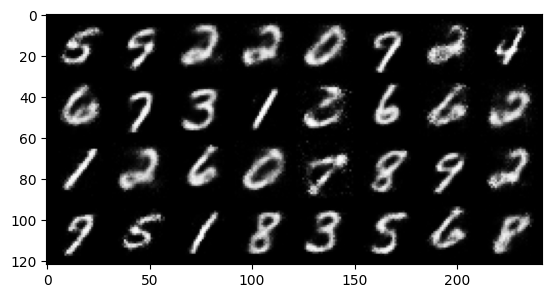

In [98]:
show_adn_save("real",make_grid(rbm.sample_visible(rbm.sample_hidden(batch)[0])[0].view(32,1,28,28).data))